In [51]:
import numpy as np
import matplotlib.pyplot as plt
import math 
from PyAstronomy import pyasl
%matplotlib inline

In [52]:
# # HMM input
# Tot=300
# dt=0.01
# dtau=0.01
# T=np.arange(dtau,Tot,dtau)
# G = 10
# w = G/(2*1.06)
# D=4
# L=np.zeros(len(T))
# V=np.zeros(len(T))
# mu, sigma = 0, 1
# for i in range(len(T)-1):
#     L[i+1]=L[i]+V[i]*dt
#     V[i+1]=(1-G*dt)*V[i]-w**2*L[i]*dt+math.sqrt(D*dt)*np.random.normal(mu, sigma)
# plt.plot(T,L)
# plt.xlim()

(-14.989000000000003, 314.98900000000003)

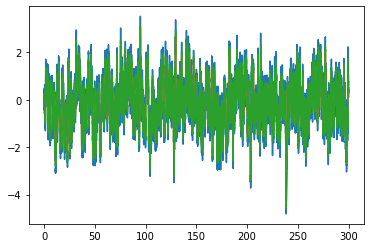

In [53]:
# OU
Tot=300
dt=0.01
dtau=0.01
T=np.arange(dtau,Tot,dtau)
tau=0.5
D = 4
L=np.zeros(len(T))
mu, sigma = 0, 1
for i in range(len(T)-1):
    L[i+1]=L[i]*(1-dt/tau)+math.sqrt(D*dt)*np.random.normal(mu,sigma)
Ls=pyasl.smooth(L,21,'flat') # data smoothing
R=np.zeros(len(L))
R=L-Ls
r=0.4
LsR=Ls+r*R
plt.plot(T,L)
plt.plot(T,Ls)
plt.plot(T,LsR)
plt.xlim()

In [54]:
# # HMM and OU of indentical randomness trajectory
# Tot=300
# dt=0.01
# T=np.arange(dt,Tot,dt)
# R=np.random.normal(mu,sigma,len(T))
# # HMM
# G = 5
# w = G/(2*1.06)
# D=4
# L1=np.zeros(len(T))
# V1=np.zeros(len(T))
# mu, sigma = 0, 1
# for i in range(len(T)-1):
#     L1[i+1]=L1[i]+V1[i]*dt
#     V1[i+1]=(1-G*dt)*V1[i]-w**2*L1[i]*dt+math.sqrt(D*dt)*R[i]
# # OU
# tau=0.3
# L2=np.zeros(len(T))
# mu, sigma = 0, 1
# for i in range(len(T)-1):
#     L2[i+1]=L2[i]*(1-dt/tau)+math.sqrt(D*dt)*R[i]


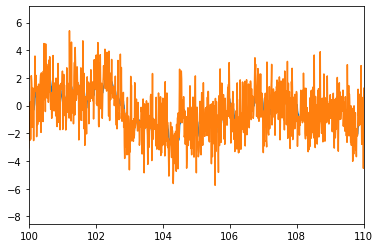

In [55]:
# UNGD output
x=L
m=12
b=(3+m)/2
FBsum=np.zeros(len(L))
for k in range(m):
    fb=np.zeros(len(x))
    for i in range(len(x)):
        ck=(k+1)/m
        ytime=i/dt-(m-k)*dt
        ind=int(ytime*dt)
        if ind>0:
            fb[i]=ck*x[ind]
        elif ind<=0:
            fb[i]=0
    FBsum=FBsum+fb
y=(3+m)/2*x-FBsum
plt.plot(T,L)
plt.plot(T,y)
plt.xlim(100,110)
plt.show()

[       -inf -1.24861449 -0.78763785 -0.45472615  0.          0.15864396
  0.52388034  0.99833618         inf]
[       -inf -2.10238108 -1.29001303 -0.68584444  0.          0.39584124
  1.00901849  1.83102068         inf]


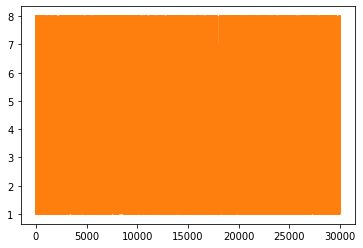

29999 29999 29999


In [56]:
# assign data to different state
# state number should be even
nx=8
ny=8

# states of input
xs=x
xs=np.sort(x)
xstatestep=len(xs)/nx
xinterval=[0]
for i in range(int(nx/2-1)):
    xinterval=np.append(xinterval,xs[round(len(xs)/2)+(i+1)*round(xstatestep)])
xinterval=np.append(xinterval,float('inf'))
for j in range(int(nx/2-1)):
    xinterval=np.append(xs[round(len(xs)/2)-(j+1)*round(xstatestep)],xinterval)
xinterval=np.append(float('-inf'),xinterval)
print(xinterval)
xstate=np.zeros(len(x))
for i in range(len(x)):
    tempinterval=[]
    state=[]
    tempinterval=np.array(xinterval)
    tempinterval=np.append(tempinterval,x[i])
    tempinterval=np.sort(tempinterval)
    state=np.where(tempinterval==x[i])
    xstate[i]=state[0][0]

# states of output
ys=y
ys=np.sort(y)
ystatestep=len(ys)/ny
yinterval=[0]
for i in range(int(ny/2-1)):
    yinterval=np.append(yinterval,ys[round(len(ys)/2)+(i+1)*round(ystatestep)])
yinterval=np.append(yinterval,float('inf'))
for j in range(int(ny/2-1)):
    yinterval=np.append(ys[round(len(ys)/2)-(j+1)*round(ystatestep)],yinterval)
yinterval=np.append(float('-inf'),yinterval)
print(yinterval)
ystate=np.zeros(len(y))
for i in range(len(y)):
    tempinterval=[]
    state=[]
    tempinterval=np.array(yinterval)
    tempinterval=np.append(tempinterval,y[i])
    tempinterval=np.sort(tempinterval)
    state=np.where(tempinterval==y[i])
    ystate[i]=state[0][0]
    
plt.plot(xstate)
plt.plot(ystate)
plt.xlim()
plt.show()
print(len(xstate),len(ystate),len(y))


In [57]:
# calculating mutual information
negshift=-1 # second
posshift=1 # second
shiftdu=dt # second
shiftlen=(posshift-negshift)/dt+1
timeshift=np.linspace(negshift,posshift,shiftlen)
bitshift=np.linspace(negshift/dt,posshift/dt,shiftlen)
xedges=np.linspace(1,nx+1,nx+1) # states of x
yedges=np.linspace(1,ny+1,ny+1) # states of y

# shifted data
# shift>0 => y shifted to positive side
MI=np.zeros(len(bitshift))
for i in range(len(bitshift)):
    xx=[]
    yy=[]
    shift=int(bitshift[i])
    if shift>0:
        xx=xstate[shift:]
        yy=ystate[:-shift]
    elif shift==0:
        xx=xstate
        yy=ystate
    elif shift<0:
        xx=xstate[:shift]
        yy=ystate[-shift:]

    H, xedges, yedges = np.histogram2d(xx, yy, bins=(xedges, yedges))
    statesum=np.sum(H)
    px_list=np.sum(H,axis=1)/statesum
    py_list=np.sum(H,axis=0)/statesum
    pxy_list=H/statesum
    
    MIsingle=np.zeros(len(xx))
    for j in range(len(xx)):
        px=px_list[int(xx[j]-1)]
        py=py_list[int(yy[j]-1)]
        pxy=pxy_list[int(xx[j]-1)][int(yy[j]-1)]
        MIsingle[j]=pxy*math.log2(pxy/px/py)
    MI[i]=np.sum(MIsingle)
    


(-1.1, 1.1)

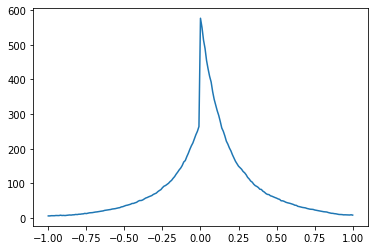

In [58]:
plt.plot(timeshift,MI)
plt.xlim()